Import libraries

In [1]:
from utils import Encoder
import utils
import torch
from datasets import RoboEireanDataModule
import lightning.pytorch as pl

from models import JetNet, SingleShotDetector, ObjectDetectionTask
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch.nn.functional as F

# Load the model

Initialize necessary parameters for model to be loaded

In [2]:
LEARNING_RATE = 1e-1
ALPHA = 2.0
NUM_CLASSES = 1
DEFAULT_SCALINGS = torch.tensor(
    [
        [0.06549374, 0.12928654],
        [0.11965626, 0.26605093],
        [0.20708716, 0.38876095],
        [0.31018215, 0.47485098],
        [0.415882, 0.8048184],
        [0.7293086, 0.8216225],
    ]
)
encoder = Encoder(DEFAULT_SCALINGS, NUM_CLASSES)
model = JetNet(NUM_CLASSES, DEFAULT_SCALINGS.shape[0])
loss = SingleShotDetector(ALPHA)

# data_module = RoboEireanDataModule("data/raw/", encoder, 128)
# data_module.setup("fit")

Load the model from checkpoint in logs

In [3]:
version = 3
checkpoint_folder = f"new_logs/lightning_logs/version_{version}/checkpoints/"
checkpoint_path = "epoch=0-step=28.ckpt"


checkpoint_path = checkpoint_folder + checkpoint_path
loaded_model = ObjectDetectionTask.load_from_checkpoint(
    checkpoint_path=checkpoint_path, 
    model=model, 
    loss=loss, 
    encoder=encoder, 
    learning_rate=LEARNING_RATE)
loaded_model

ObjectDetectionTask(
  (model): JetNet(
    (input_layer): NormConv2dReLU(
      (batch_normalization): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same, bias=False)
      (relu): ReLU()
    )
    (depth_wise_backbone): Sequential(
      (0): DepthWise(
        (batch_normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2d_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (conv2d_2): Conv2d(16, 24, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (relu): ReLU()
      )
      (1): DepthWise(
        (batch_normalization): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2d_1): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=same, groups=24, bias=False)
        (conv2d_2): Conv2d(24, 16, kernel_size=(1, 1), stride=(

In [4]:
# accessing attributes of the loaded model to verify
print(loaded_model.learning_rate)

0.1


# Load the data

In [5]:
# get the data we want to visualize and predict on
data_module = RoboEireanDataModule("data/raw/", encoder, 128)
data_module.setup("fit")  # TODO: inspect different stages

Plot some batch images using iterators

In [6]:
def plot_images(data_module, n_images, transformed=True, original=True):
    counter = 0
    # initialize an iterator over the validation data
    iterator = iter(data_module.val_dataloader())
    
    for i in range(len(iterator)):
        # get the next batch
        batch = next(iterator)
        
        # get the transformed images of the batch (e.g. 128)
        transformed_images = batch[0]
        # get the images from the batch (e.g. 128)
        images = batch[1]
        
        for i in range(images.shape[0]):
            if counter == n_images:
                break
            counter += 1
            
            if transformed:
                # get the first transformed image of the batch (shape: torch.Size([128, 1, 60, 80]))
                transformed_image = transformed_images[i:i+1,:,:,:]
                
                plt.imshow(transformed_image.squeeze(), cmap='gray')
                plt.show()
            
            if original:
                # get the first transformed image of the batch
                image = images[i:i+1,:,:,:]

                # Plot the image (1, 60, 80) -> (60, 80)
                plt.imshow(image.squeeze(), cmap='gray')
                plt.show()

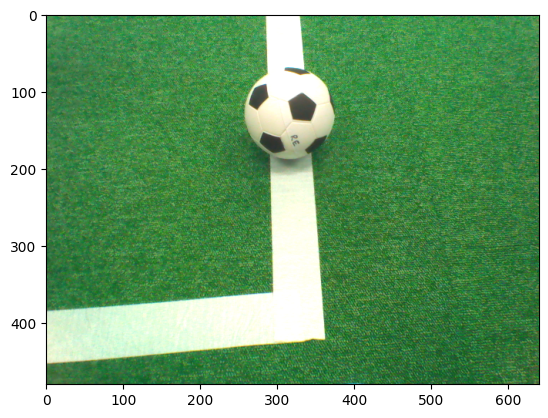

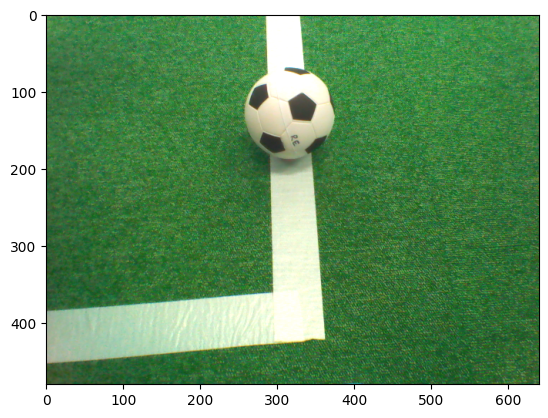

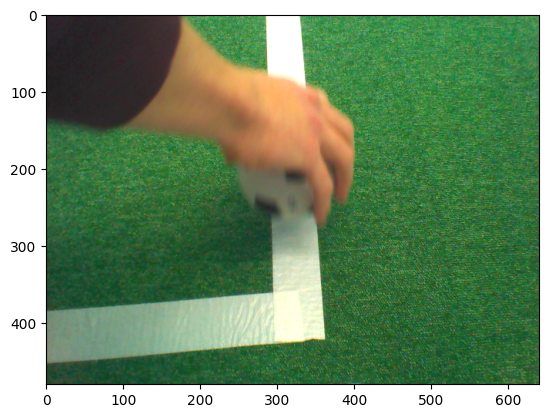

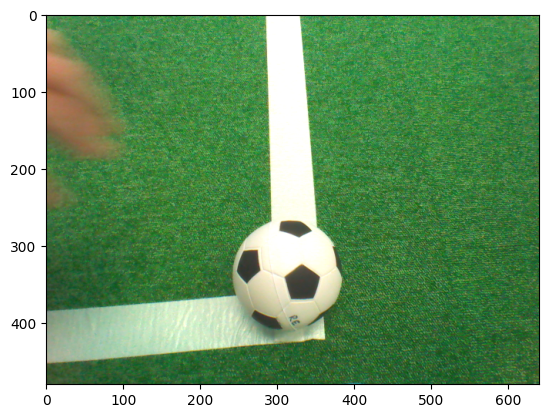

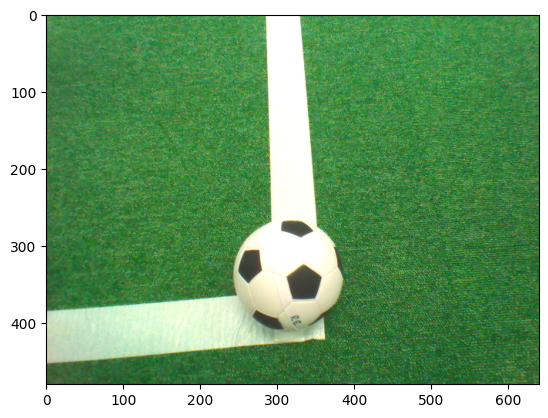

In [7]:
plot_images(data_module, 5, transformed=False)

# Make predictions

In [9]:
iterator = iter(data_module.val_dataloader())
batch = next(iterator)
transformed_images = batch[0]
transformed_image = transformed_images[0:1,:,:,:]


torch.Size([1, 1, 60, 80])


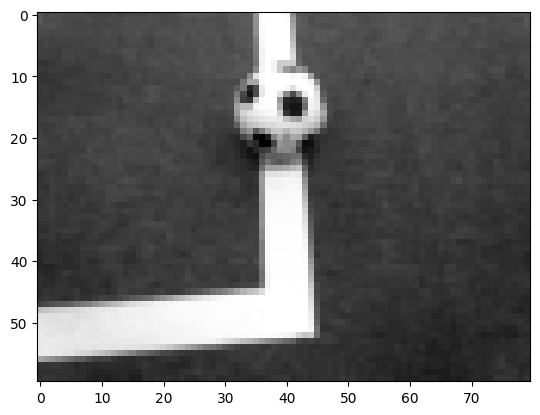

In [10]:
print(transformed_image.shape)
plt.imshow(transformed_image.squeeze(), cmap='gray')
plt.show()

In [11]:
# set the model in evaluation mode to disable training features
loaded_model.eval()

# make a prediction on the test sample
y_hat = loaded_model.model(transformed_image)

# get the predicted bounding boxes and logits
pred_bounding_boxes, pred_logits = y_hat

# Visualize bounding boxes

Visualize image without bounding box

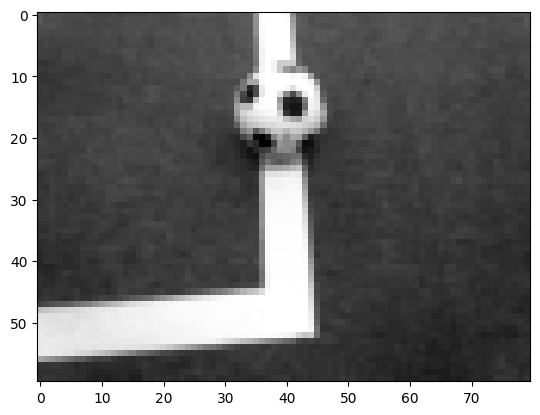

In [12]:


# Plot the image (1, 60, 80) -> (60, 80)
plt.imshow(transformed_image.squeeze(), cmap='gray')
plt.show()

Decode boumding boxes, convert to image space

In [13]:
# COCO: (xmin, ymax, width, height) 

# decode the boxes for one image, shape 1, 480, 4
boxes = loaded_model.encoder.decode(pred_bounding_boxes)  # contain values 0 - 1
print(f"box shape: {boxes.shape}")
print(f"boxes:\n", boxes)

height, width = transformed_image.squeeze().shape
print(height, width)

box shape: torch.Size([1, 480, 4])
boxes:
 tensor([[[0.0562, 0.0627, 0.0642, 0.1168],
         [0.0582, 0.0606, 0.0846, 0.2029],
         [0.0533, 0.0914, 0.1976, 0.4101],
         ...,
         [0.9617, 0.9493, 0.2556, 0.5139],
         [0.9453, 0.9503, 0.3710, 0.7388],
         [0.8385, 0.9411, 0.6572, 0.8500]]], grad_fn=<CopySlices>)
60 80


In [14]:
# convert the COCO boxes to absolute coordinates
boxes = utils.convert_to_absolute_coordinates(
            boxes, (height, width)
        )
boxes

tensor([[[ 1.9297,  0.2612,  7.0678,  7.2665],
         [ 1.2742, -2.4486,  8.0384,  9.7226],
         [-3.6361, -6.8211, 12.1713, 17.7870],
         ...,
         [66.7132, 41.5449, 87.1586, 72.3767],
         [60.7854, 34.8519, 90.4667, 79.1789],
         [40.7927, 30.9669, 93.3708, 81.9693]]], grad_fn=<CatBackward0>)

In [15]:
# get the predicted bounding boxes for the first image (128, 480, 4) -> (128, 4)
boxes = boxes[0,:,:]
boxes

tensor([[ 1.9297,  0.2612,  7.0678,  7.2665],
        [ 1.2742, -2.4486,  8.0384,  9.7226],
        [-3.6361, -6.8211, 12.1713, 17.7870],
        ...,
        [66.7132, 41.5449, 87.1586, 72.3767],
        [60.7854, 34.8519, 90.4667, 79.1789],
        [40.7927, 30.9669, 93.3708, 81.9693]], grad_fn=<SliceBackward0>)

In [16]:
transformed_image = transformed_image.squeeze()

# Get the height and width from the original image tensor shape
height, width = transformed_image.shape[0:]

# Rescale bounding boxes to original image size
boxes

tensor([[ 1.9297,  0.2612,  7.0678,  7.2665],
        [ 1.2742, -2.4486,  8.0384,  9.7226],
        [-3.6361, -6.8211, 12.1713, 17.7870],
        ...,
        [66.7132, 41.5449, 87.1586, 72.3767],
        [60.7854, 34.8519, 90.4667, 79.1789],
        [40.7927, 30.9669, 93.3708, 81.9693]], grad_fn=<SliceBackward0>)

In [17]:
# predict the logit scores (before softmax) for each class
pred_logits[:-10]

tensor([], size=(0, 480, 2), grad_fn=<SliceBackward0>)

Get the predicted class for each bounding box

In [18]:
_, _, num_classes = pred_logits.shape

# softmax scores for each class (dim 2 is the class dimension)
predicted_class_scores = F.softmax(pred_logits, dim=2)

In [19]:
predicted_class_scores

tensor([[[0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
         [0.7463, 0.2537],
         [0.7413, 0.2587],
         [0.7651, 0.2349],
         [0.7566, 0.2434],
         [0.7925, 0.2075],
         [0.7784, 0.2216],
 

In [20]:
# get the highest for each bounding box (dim 2 because we want to compare the classes)
predicted_class = predicted_class_scores.argmax(dim=2)
predicted_class

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0

Determine best bounding boxes

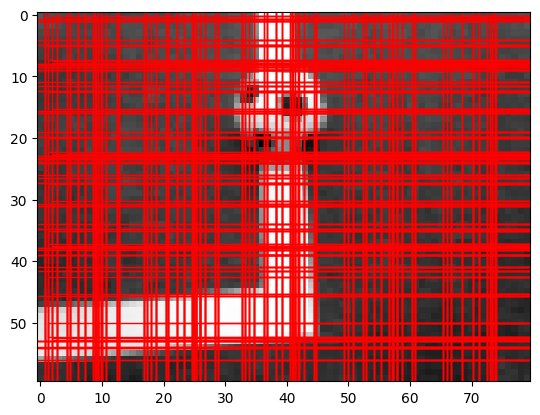

In [21]:

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(transformed_image, cmap='gray')

for box in boxes:
    xmin = box[0].detach().numpy()
    ymax = box[1].detach().numpy()
    width = box[2].detach().numpy()
    height =  box[3].detach().numpy()

    # Create a Rectangle patch
    rect = patches.Rectangle((xmin, ymax), width, height, linewidth=1, edgecolor='r', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()
